In [1]:
import cv2
import pandas as pd


In [2]:
## I THINK THIS IS OUTDATED.... JUST USE CELL BELOW

# import cv2
# vidcap = cv2.VideoCapture('data/train.mp4')
# success,image = vidcap.read()
# count = 0
# while success:
#     cv2.imwrite("data/train_imgs/frame%d.jpg" % count, image)     # save frame as JPEG file      
#     success,image = vidcap.read()
#     print('Read a new frame: ', success)
#     count += 1

In [4]:

# import cv2 
  
# # Function to extract frames 
# def FrameCapture(path): 
      
#     # Path to video file 
#     vidObj = cv2.VideoCapture(path) 
  
#     # Used as counter variable 
#     count = 0
  
#     # checks whether frames were extracted 
#     success = 1
  
#     while success: 
  
#         # vidObj object calls read 
#         # function extract frames 
#         success, image = vidObj.read() 
  
#         # Saves the frames with frame-count 
#         cv2.imwrite("data/train_imgs/frame%d.jpg" % count, image) 
  
#         count += 1
  

#     # Calling the function 
# FrameCapture('data/train.mp4') 

In [5]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)



Using TensorFlow backend.


In [6]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import keras
import skimage
import tensorflow
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import skimage.morphology as morp
from skimage.filters import rank

%matplotlib inline

assert pd.__version__ == '0.23.4'
assert np.__version__ == '1.15.4'
assert keras.__version__ == '2.1.3'
assert skimage.__version__ == '0.14.1'
assert sklearn.__version__ == '0.19.2'
assert tensorflow.__version__ == '1.12.0'


In [7]:
# Load all images

import os
import skimage.data
def load_data(data_dir):
    images = []
    
    file_names = sorted([os.path.join(data_dir, f)
                  for f in os.listdir(data_dir) if f.endswith(".jpg")])
    
    for f in file_names:
        images.append(skimage.data.imread(f)) #as_gray=True))
    
    return images

images = load_data('data/train_imgs')
print(len(images))

20400


In [8]:
# Explore shapes
for image in images[:3]:
    print('image.shape[before]', image.shape)

image.shape[before] (480, 640, 3)
image.shape[before] (480, 640, 3)
image.shape[before] (480, 640, 3)


In [9]:
# Transform images

import skimage.transform
image_size = (60,80,3)
images_transformed = [skimage.transform.resize(image, image_size) for image in images]

# Confirm transformation shape
for image in images_transformed[:3]:
    print('image.shape[after]', image.shape)
    

image.shape[after] (60, 80, 3)
image.shape[after] (60, 80, 3)
image.shape[after] (60, 80, 3)


In [10]:
del images

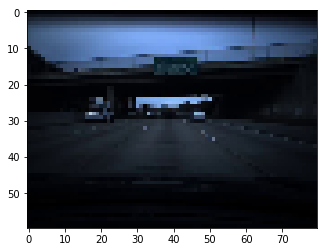

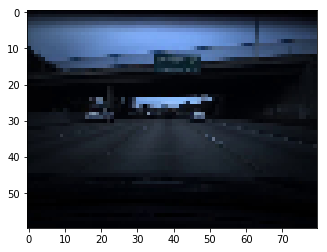

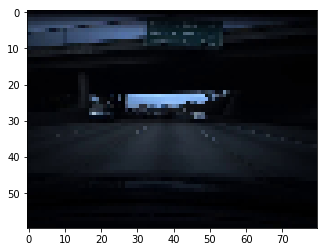

In [11]:
from PIL import Image

for image in images_transformed[:3]:
    image = (image * 255).astype(np.uint8)
    im = Image.fromarray(image)
    plt.figure()
    plt.imshow(im)
    plt.show()



In [12]:
# Load Labels 

import pandas as pd

data = pd.read_csv("data/train.txt", header=None, names=['Speed'])
labels = data["Speed"]

labels.head()

0    28.105569
1    28.105569
2    28.106527
3    28.130404
4    28.109243
Name: Speed, dtype: float64

In [13]:
# Categorize labels..
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y = np.array(labels)
X = np.array(images_transformed)
X = X[:, :, :]  

print('len(X)', len(X))
print('len(y)', len(y))


len(X) 20400
len(y) 20400


In [14]:
X.shape

(20400, 60, 80, 3)

In [15]:
# 80/20 Train-test split

train_size = int(0.8 * X.shape[0])

X_train = X[0:train_size,:,:]
X_test = X[train_size:,:,:]
y_train = y[0:train_size]
y_test = y[train_size:]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# # BASELINE MODEL -- Feedforward network
# model = Sequential()
# model.add(Flatten(input_shape=image_size))
# model.add(Dense(units=120,activation="relu"))
# model.add(Dense(units=120,activation="relu"))
# model.add(Dense(units=1,activation="softmax"))
# model.compile(optimizer="adam",loss="mean_squared_error",metrics=["mse"])

In [17]:
# %time model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

In [18]:
# # Feedforward model accuracy
# accuracy = model.evaluate(x=X_test,y=y_test,batch_size=32, verbose=0)
# print("Loss:", round(accuracy[0],4))

In [22]:
del X

In [24]:
import pickle 

# with open('X_train.pickle', 'wb') as f:
#     pickle.dump(X_train, f)
    
with open('X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)

In [25]:
X_train.shape

(16320, 60, 80, 3)

In [26]:
time_steps = 20

X_train_seqs = []
for i in range(0,X_train.shape[0]-time_steps):
    x_new = X_train[i:i+time_steps,:,:]
    X_train_seqs.append(x_new)
X_train_seqs = np.array(X_train_seqs)
X_train_seqs = np.array(X_train_seqs)

del X_train
X_train_seqs.shape

(16300, 20, 60, 80, 3)

In [ ]:
y_train_cut = y_train[time_steps:]
y_train_cut.shape


In [ ]:
from keras.layers import TimeDistributed

# time_steps = 20

model = Sequential()
# define CNN model
model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same'),
                          input_shape=(time_steps,)+image_size))
model.add(TimeDistributed(MaxPool2D(pool_size=(2,2))))
model.add(TimeDistributed(Dropout(0.1)))
model.add(TimeDistributed(Conv2D(1, (4, 4), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPool2D(pool_size=(3,3))))
model.add(TimeDistributed(Dropout(0.1)))
model.add(TimeDistributed(Flatten()))

# define LSTM model
model.add(LSTM(5, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=1,activation="softmax"))
model.compile(optimizer="adam",loss="mean_squared_error",metrics=["mse"])
print(model.summary())
          
         


In [ ]:
%time model.fit(X_train_seqs, y_train_cut, epochs=1, batch_size=16, verbose=1)